## This project classifies butterfly images using CNN Model.
## Dataset has 75 class and 6500 image.

In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
# import autokeras as ak
# from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings
import pathlib
warnings.filterwarnings("ignore", category=UserWarning, message=r"Your `PyDataset` class should call `super().__init__\(\*\*kwargs\)`")

2025-09-26 20:06:59.243168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758917219.267873    4634 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758917219.275130    4634 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
PATH = ""
SIZE = 224
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path(Current_Dir)
print(dataset_dir)

/kaggle/working


In [3]:
train = pd.read_csv("/kaggle/input/butterfly-image-classification/Training_set.csv")
test = pd.read_csv("/kaggle/input/butterfly-image-classification/Testing_set.csv")
train

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART
...,...,...
6494,Image_6495.jpg,MANGROVE SKIPPER
6495,Image_6496.jpg,MOURNING CLOAK
6496,Image_6497.jpg,APPOLLO
6497,Image_6498.jpg,ELBOWED PIERROT


In [4]:
test

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg
...,...
2781,Image_2782.jpg
2782,Image_2783.jpg
2783,Image_2784.jpg
2784,Image_2785.jpg


In [5]:
def generate_path(df, train_or_test:str):
    #Define the path and add as a new column
    df['path'] = df['filename'].map(lambda x: os.path.join(PATH, train_or_test, x))

In [6]:
generate_path(train, os.path.join("/kaggle/input/butterfly-image-classification", "train"))
generate_path(test, os.path.join("/kaggle/input/butterfly-image-classification", "test"))

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7967CBBF3F90>


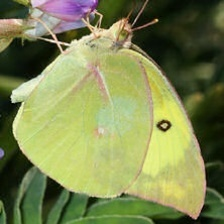

In [7]:
img = load_img(train.path[0])
print(img)
img

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7967CBB477D0>


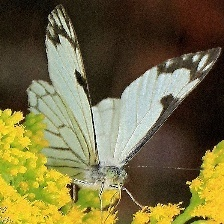

In [8]:
img = load_img(test.path[0])
print(img)
img

In [9]:
"""def resize_image(df):
    #Use the path to read images.
    skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))
"""

"def resize_image(df):\n    #Use the path to read images.\n    skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))\n"

In [10]:
def print_label_count(df):
    class_counts = df['label'].value_counts().sort_index()
    plt.figure(figsize=(14, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title('Distribution of Butterfly Classes')
    plt.xlabel('Butterfly Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

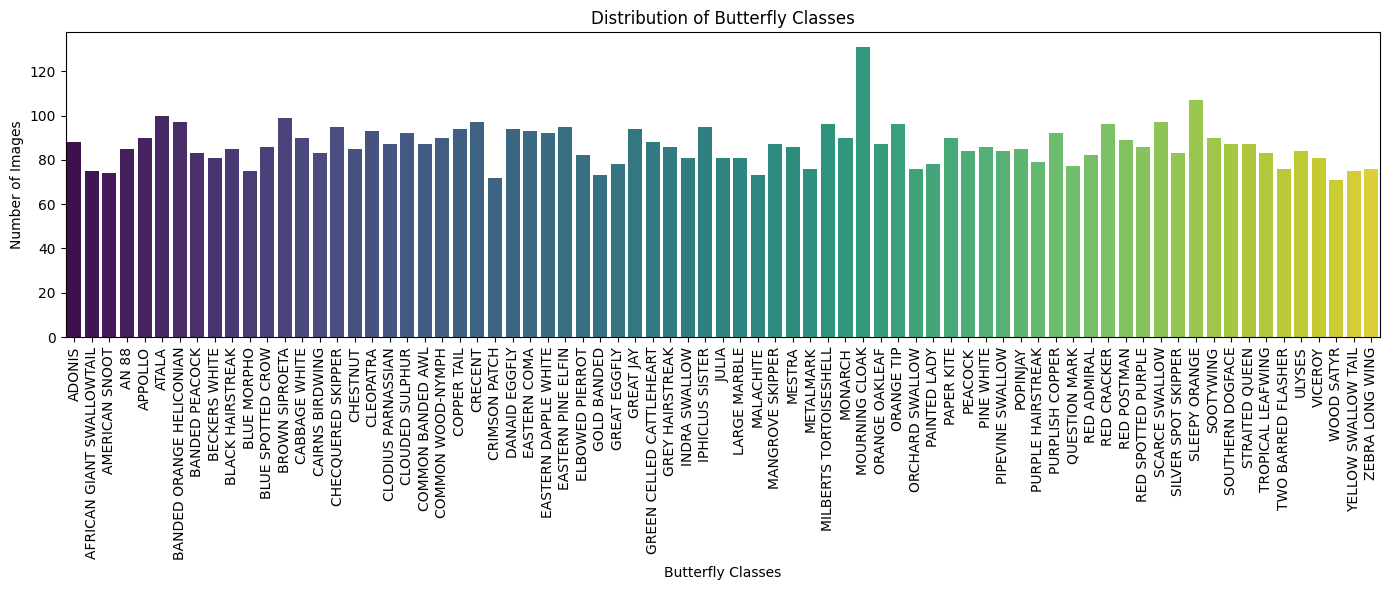

In [11]:
print_label_count(train)

### The dataset is fairly balanced, but data augmentation is needed to increase the number of samples.

In [12]:
def plot_rand_img(df):
    sample_images = df.sample(9, random_state=42)
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    
    for i, (index, row) in enumerate(sample_images.iterrows()):
        img_path = row['path']
        img = load_img(img_path, target_size=(150, 150))
        img_array = img_to_array(img) / 255.0  # Normalize the image
        
        ax = axes[i // 3, i % 3]
        ax.imshow(img_array)
        ax.set_title(f"Class: {row['label']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

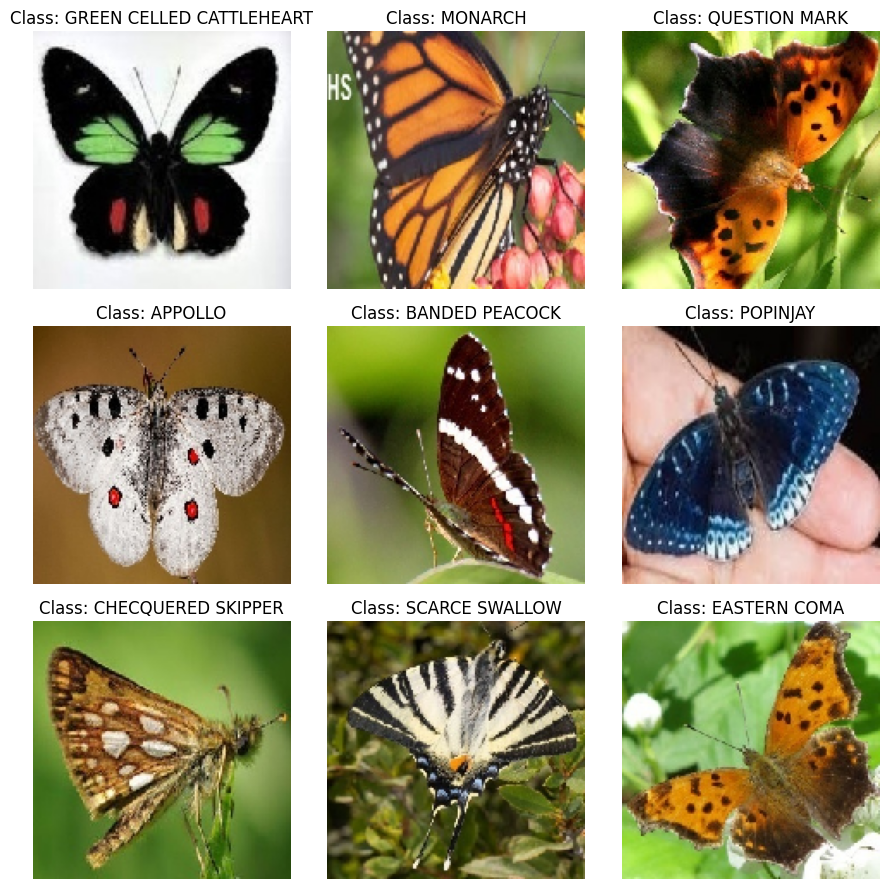

In [13]:
plot_rand_img(train)

### As we can see some butterflies are vertical and angled so data augmentation can be applied.

## Image Data Generator

Image datas are generated with these modes : rescale, rotation_range, width_shift_range, <br>
height_shift_range,brightness_range, shear_range, zoom_range, horizontal_flip, fill_mode='nearest' <br>

In [14]:
def image_data_generator(df, image_dir, SIZE=224, samples_per_image=3, aug_tag="aug", input_folder_name="input1", output_subdir="augmented_images2"):
    # Output directory
    output_dir = os.path.join("/kaggle/input", input_folder_name, output_subdir)
    os.makedirs(output_dir, exist_ok=True)

    # Data augmentation generator
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.8, 1],
        shear_range=30,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    records = []

    for idx, row in df.iterrows():
        fname = row['filename']
        label = row['label']
        img_path = os.path.join(image_dir, fname)

        # Orijinal resmi yükle
        img = load_img(img_path, target_size=(SIZE, SIZE))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # Augmentation ile yeni görseller üret
        aug_iter = train_datagen.flow(x, batch_size=1)
        for j in range(samples_per_image):
            aug_img = next(aug_iter)[0] * 255  # rescale geri çevir
            aug_img = aug_img.astype(np.uint8)

            new_name =  f"{base}_{aug_tag}{j+1}{ext}"
            save_path = os.path.join(output_dir, new_name)

            Image.fromarray(aug_img).save(save_path)
            records.append({"filename": new_name, "label": label})

    augmented_df = pd.DataFrame(records)
    return augmented_df

### I tried 3 sample for each image and recognized it is not enough. Them I augmented again 3 sample from each image. 
### I have not enough time so first augmented image is augmented_df and the second part is temp_df. Then I concat them to get full augmented df.

Before data augmentation : 6499
Augmented data length : 19497


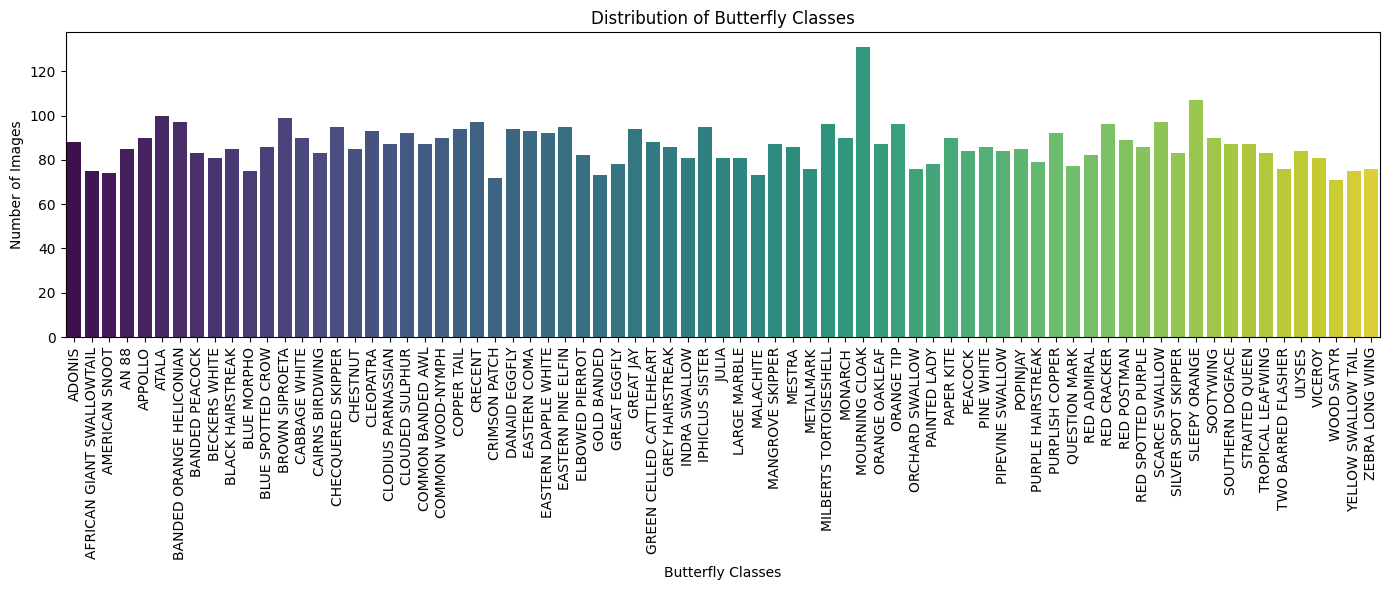

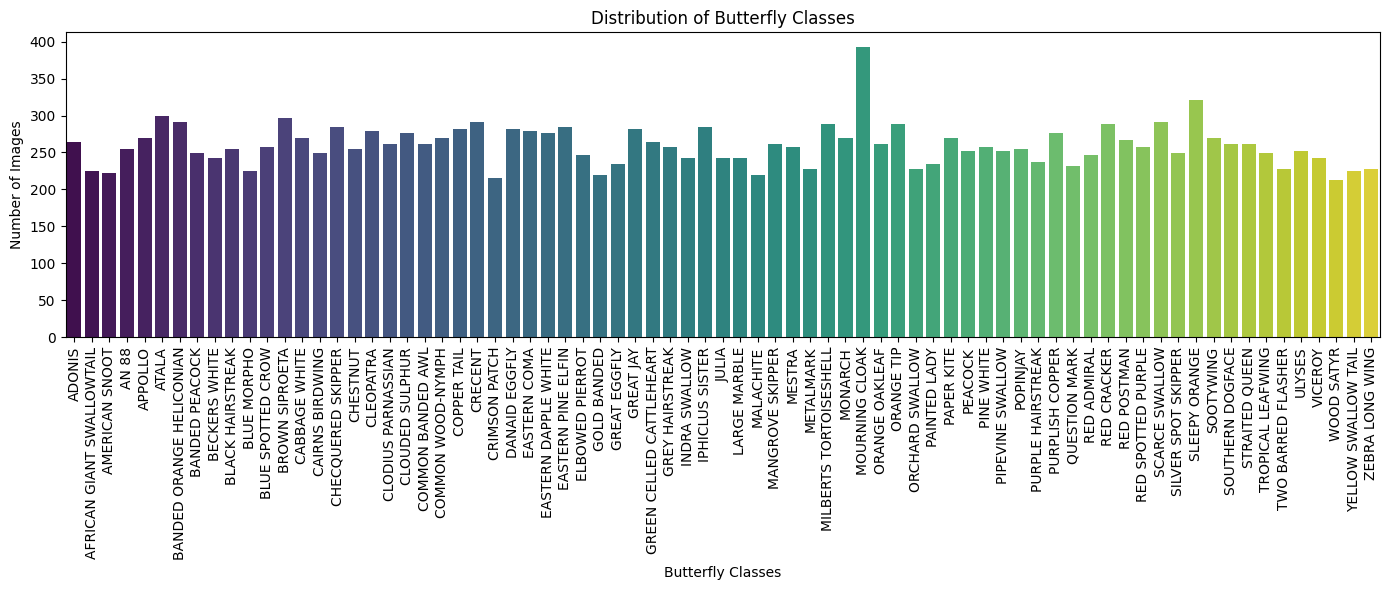

CPU times: user 1.29 s, sys: 57 ms, total: 1.35 s
Wall time: 1.35 s


In [15]:
%%time
import shutil
import os

print(f"Before data augmentation : {len(train)}")
augmented_df = pd.read_csv("/kaggle/input/input1/augmented_df.csv") # image_data_generator(train, PATH+"train/")
temp_df = pd.read_csv("/kaggle/input/input2/augmented_df2.csv") # image_data_generator(train, PATH+"train/", aug_tag="second", input_folder_name="input2", output_subdir="augmented_images3")
print(f"Augmented data length : {len(augmented_df)}")

print_label_count(train)
print_label_count(augmented_df)

In [16]:
augmented_df

,filename,label
0,Image_1_aug1.jpg,SOUTHERN DOGFACE
1,Image_1_aug2.jpg,SOUTHERN DOGFACE
2,Image_1_aug3.jpg,SOUTHERN DOGFACE
3,Image_2_aug1.jpg,ADONIS
4,Image_2_aug2.jpg,ADONIS
...,...,...
19492,Image_6498_aug2.jpg,ELBOWED PIERROT
19493,Image_6498_aug3.jpg,ELBOWED PIERROT
19494,Image_6499_aug1.jpg,ATALA
19495,Image_6499_aug2.jpg,ATALA


/kaggle/input/input1/augmented_images2/augmented_images2/Image_1_aug1.jpg


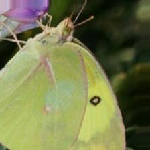

In [17]:
aug_path = os.path.join("/kaggle/input/input1/augmented_images2", "augmented_images2")
aug_path_2 = os.path.join("/kaggle/input/input2/augmented_images3", "augmented_images3")
generate_path(augmented_df, aug_path)
generate_path(temp_df, aug_path_2)

augmented_df = pd.concat([augmented_df, temp_df], axis=0)
augmented_df.reset_index(drop=True, inplace=True)

print(augmented_df.path[0])
img_path = augmented_df.path[0]
img = load_img(img_path, target_size=(150, 150))
img

/kaggle/input/butterfly-image-classification/train/Image_1.jpg


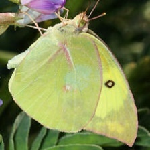

In [18]:
print(train.path[0])
img_path = train.path[0]
img = load_img(img_path, target_size=(150, 150))
img

In [19]:
train

,filename,label,path
0,Image_1.jpg,SOUTHERN DOGFACE,/kaggle/input/butterfly-image-classification/t...
1,Image_2.jpg,ADONIS,/kaggle/input/butterfly-image-classification/t...
2,Image_3.jpg,BROWN SIPROETA,/kaggle/input/butterfly-image-classification/t...
3,Image_4.jpg,MONARCH,/kaggle/input/butterfly-image-classification/t...
4,Image_5.jpg,GREEN CELLED CATTLEHEART,/kaggle/input/butterfly-image-classification/t...
...,...,...,...
6494,Image_6495.jpg,MANGROVE SKIPPER,/kaggle/input/butterfly-image-classification/t...
6495,Image_6496.jpg,MOURNING CLOAK,/kaggle/input/butterfly-image-classification/t...
6496,Image_6497.jpg,APPOLLO,/kaggle/input/butterfly-image-classification/t...
6497,Image_6498.jpg,ELBOWED PIERROT,/kaggle/input/butterfly-image-classification/t...


In [20]:
augmented_df

,filename,label,path
0,Image_1_aug1.jpg,SOUTHERN DOGFACE,/kaggle/input/input1/augmented_images2/augment...
1,Image_1_aug2.jpg,SOUTHERN DOGFACE,/kaggle/input/input1/augmented_images2/augment...
2,Image_1_aug3.jpg,SOUTHERN DOGFACE,/kaggle/input/input1/augmented_images2/augment...
3,Image_2_aug1.jpg,ADONIS,/kaggle/input/input1/augmented_images2/augment...
4,Image_2_aug2.jpg,ADONIS,/kaggle/input/input1/augmented_images2/augment...
...,...,...,...
38989,Image_6498_second2.jpg,ELBOWED PIERROT,/kaggle/input/input2/augmented_images3/augment...
38990,Image_6498_second3.jpg,ELBOWED PIERROT,/kaggle/input/input2/augmented_images3/augment...
38991,Image_6499_second1.jpg,ATALA,/kaggle/input/input2/augmented_images3/augment...
38992,Image_6499_second2.jpg,ATALA,/kaggle/input/input2/augmented_images3/augment...


In [21]:
all_df = pd.concat([train, augmented_df], axis=0)
all_df.reset_index(drop=True, inplace=True)
all_df

,filename,label,path
0,Image_1.jpg,SOUTHERN DOGFACE,/kaggle/input/butterfly-image-classification/t...
1,Image_2.jpg,ADONIS,/kaggle/input/butterfly-image-classification/t...
2,Image_3.jpg,BROWN SIPROETA,/kaggle/input/butterfly-image-classification/t...
3,Image_4.jpg,MONARCH,/kaggle/input/butterfly-image-classification/t...
4,Image_5.jpg,GREEN CELLED CATTLEHEART,/kaggle/input/butterfly-image-classification/t...
...,...,...,...
45488,Image_6498_second2.jpg,ELBOWED PIERROT,/kaggle/input/input2/augmented_images3/augment...
45489,Image_6498_second3.jpg,ELBOWED PIERROT,/kaggle/input/input2/augmented_images3/augment...
45490,Image_6499_second1.jpg,ATALA,/kaggle/input/input2/augmented_images3/augment...
45491,Image_6499_second2.jpg,ATALA,/kaggle/input/input2/augmented_images3/augment...


In [22]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
all_df['label_encoded'] = le.fit_transform(all_df['label'])
print(all_df[['label', 'label_encoded']].head())

                      label  label_encoded
0          SOUTHERN DOGFACE             66
1                    ADONIS              0
2            BROWN SIPROETA             12
3                   MONARCH             44
4  GREEN CELLED CATTLEHEART             33


In [23]:
all_df.drop(columns="label", inplace=True)
all_df.rename(columns={"label_encoded": "label"}, inplace=True)
all_df

,filename,path,label
0,Image_1.jpg,/kaggle/input/butterfly-image-classification/t...,66
1,Image_2.jpg,/kaggle/input/butterfly-image-classification/t...,0
2,Image_3.jpg,/kaggle/input/butterfly-image-classification/t...,12
3,Image_4.jpg,/kaggle/input/butterfly-image-classification/t...,44
4,Image_5.jpg,/kaggle/input/butterfly-image-classification/t...,33
...,...,...,...
45488,Image_6498_second2.jpg,/kaggle/input/input2/augmented_images3/augment...,29
45489,Image_6498_second3.jpg,/kaggle/input/input2/augmented_images3/augment...,29
45490,Image_6499_second1.jpg,/kaggle/input/input2/augmented_images3/augment...,5
45491,Image_6499_second2.jpg,/kaggle/input/input2/augmented_images3/augment...,5


In [24]:
#Global initialization of some imp variables
Image_Size = 224
Resize_SIZE = 128
Batch_Size = 32
Channels = 3
Epochs = 50
Output_Size = all_df.label.nunique()

In [25]:
def load_image_to_array(path):
    img = Image.open(path).convert("RGB")  # RGB
    img = img.resize((Image_Size, Image_Size))
    img_array = np.array(img, dtype=np.float32) / 255.0  # 0-1 arası normalize
    return img_array

# all_df['image_array'] = all_df['path'].apply(load_image_to_array)
# all_df = all_df[['image_array', 'label']]
all_df

,filename,path,label
0,Image_1.jpg,/kaggle/input/butterfly-image-classification/t...,66
1,Image_2.jpg,/kaggle/input/butterfly-image-classification/t...,0
2,Image_3.jpg,/kaggle/input/butterfly-image-classification/t...,12
3,Image_4.jpg,/kaggle/input/butterfly-image-classification/t...,44
4,Image_5.jpg,/kaggle/input/butterfly-image-classification/t...,33
...,...,...,...
45488,Image_6498_second2.jpg,/kaggle/input/input2/augmented_images3/augment...,29
45489,Image_6498_second3.jpg,/kaggle/input/input2/augmented_images3/augment...,29
45490,Image_6499_second1.jpg,/kaggle/input/input2/augmented_images3/augment...,5
45491,Image_6499_second2.jpg,/kaggle/input/input2/augmented_images3/augment...,5


# Train Test Split

In [26]:
all_df.drop(columns="filename", inplace=True)

In [27]:
all_df = all_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [28]:
train_df, val_df = train_test_split(all_df, test_size=0.3, random_state=42, stratify=all_df['label'])
test_df, val_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df['label'])

In [29]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(all_df), len(train_df), len(test_df), len(val_df)))

Size of Data is :45493 
Batch size of Training Data is :31845
Batch size of Validation Data is :6824 
Batch size of Testing Data is :6824 


In [30]:
def generator(filepaths, labels):
    for fp, lbl in zip(filepaths, labels):
        # Diskten oku
        img = tf.io.read_file(fp)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, [Resize_SIZE, Resize_SIZE])
        img = tf.cast(img, tf.float16) / 255.0  # normalize ve float16
        # Blur image
        # img = tfa.image.gaussian_filter2d(img, filter_shape=(4,4), sigma=1.0)
        # img = blur_image(img)  # blur uygula
        yield img, tf.cast(lbl, tf.int32)


def create_ds(df, Image_Size = Image_Size, Batch_Size=Batch_Size):
    # filepaths ve labels listesi
    filepaths = df['path'].tolist()  # ya da disk yolu
    labels = df['label'].tolist()
    
    dataset = tf.data.Dataset.from_generator(
        lambda: generator(filepaths, labels),
        output_signature=(
            tf.TensorSpec(shape=(Resize_SIZE, Resize_SIZE, 3), dtype=tf.float16),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
  
    ds = dataset.shuffle(1000).batch(Batch_Size).prefetch(tf.data.AUTOTUNE)
    return ds

In [31]:
train_ds = create_ds(train_df)
test_ds = create_ds(test_df)
val_ds = create_ds(val_df)

I0000 00:00:1758917225.914345    4634 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758917225.915014    4634 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [32]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [33]:
images, labels = next(iter(train_ds))
print(images.shape)  # (Batch_Size, 224, 224, 3)
print(labels.shape)  # (Batch_Size,)

(32, 128, 128, 3)
(32,)


# After several attempts, the selected CNN model is shown below.

In [37]:
%%time
input_shape = (Resize_SIZE, Resize_SIZE, Channels)
num_of_epoch = 25
model_2 = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), padding = 'same', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), padding = 'same', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(256, (3,3), padding = 'same', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), padding = 'same', kernel_regularizer=regularizers.l2(0.001), kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),      # 20% nöronlar rastgele kapatılır 0.2 yapayim
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.3),      # 20% nöronlar rastgele kapatılır
    layers.Dense(Output_Size, activation='softmax')
    
])

model_2.summary()
model_2.build()

model_2.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,   # yarıya indir
                              patience=3,   # 3 epoch boyunca iyileşme yoksa
                              min_lr=1e-6)

with tf.device('/GPU:0'):
    history_2 = model_2.fit(train_ds, epochs = num_of_epoch, batch_size = Batch_Size, verbose = 1, validation_data = val_ds, callbacks=[early_stopping, reduce_lr])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 64)       │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             

 Total params: 624,971 (2.38 MB)

 Trainable params: 623,947 (2.38 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/25


I0000 00:00:1758917262.554716    4690 service.cc:148] XLA service 0x7966b003d2e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758917262.554766    4690 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758917262.554771    4690 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758917263.140936    4690 cuda_dnn.cc:529] Loaded cuDNN version 90300


      3/Unknown 15s 78ms/step - accuracy: 0.0191 - loss: 5.8117

I0000 00:00:1758917268.494221    4690 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    996/Unknown 168s 154ms/step - accuracy: 0.0806 - loss: 4.5854

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


996/996 ━━━━━━━━━━━━━━━━━━━━ 201s 187ms/step - accuracy: 0.0806 - loss: 4.5848 - val_accuracy: 0.1583 - val_loss: 3.6361 - learning_rate: 0.0010
Epoch 2/25
996/996 ━━━━━━━━━━━━━━━━━━━━ 139s 137ms/step - accuracy: 0.2564 - loss: 2.9282 - val_accuracy: 0.3958 - val_loss: 2.4843 - learning_rate: 0.0010
Epoch 3/25
996/996 ━━━━━━━━━━━━━━━━━━━━ 140s 137ms/step - accuracy: 0.3685 - loss: 2.5145 - val_accuracy: 0.4831 - val_loss: 2.0644 - learning_rate: 0.0010
Epoch 4/25
996/996 ━━━━━━━━━━━━━━━━━━━━ 139s 137ms/step - accuracy: 0.4367 - loss: 2.2536 - val_accuracy: 0.5006 - val_loss: 2.0390 - learning_rate: 0.0010
Epoch 5/25
996/996 ━━━━━━━━━━━━━━━━━━━━ 138s 136ms/step - accuracy: 0.4921 - loss: 2.0556 - val_accuracy: 0.5227 - val_loss: 1.9738 - learning_rate: 0.0010
Epoch 6/25
996/996 ━━━━━━━━━━━━━━━━━━━━ 138s 136ms/step - accuracy: 0.5300 - loss: 1.9423 - val_accuracy: 0.4505 - val_loss: 2.3918 - learning_rate: 0.0010
Epoch 7/25
996/996 ━━━━━━━━━━━━━━━━━━━━ 138s 136ms/step - accuracy: 0.5628 

In [38]:
import matplotlib.pyplot as plt

def plot_training_history(history, early_stopping=None, num_of_epoch=None):
    """
    Training ve validation accuracy ile loss grafiğini çizer.

    Args:
        history: Keras model.fit() sonrası dönen History objesi
        early_stopping: EarlyStopping callback objesi (opsiyonel)
        num_of_epoch: Modelin toplam epoch sayısı (opsiyonel, early stopping yoksa kullanılır)
    """
    # Training ve validation değerlerini al
    train_loss = history.history['loss']
    train_acc = history.history['accuracy']
    val_loss = history.history.get('val_loss')
    val_acc = history.history.get('val_accuracy')

    # Grafiğin x eksenini belirle
    if early_stopping is not None and early_stopping.stopped_epoch > 0:
        rng = early_stopping.stopped_epoch + 1
    elif num_of_epoch is not None:
        rng = num_of_epoch
    else:
        rng = len(train_acc)

    # Grafik çizimi
    plt.figure(figsize=(15, 6))

    # Accuracy grafiği
    plt.subplot(1, 2, 1)
    plt.plot(range(rng), train_acc[:rng], label='Training Accuracy')
    if val_acc is not None:
        plt.plot(range(rng), val_acc[:rng], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss grafiği
    plt.subplot(1, 2, 2)
    plt.plot(range(rng), train_loss[:rng], label='Training Loss')
    if val_loss is not None:
        plt.plot(range(rng), val_loss[:rng], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

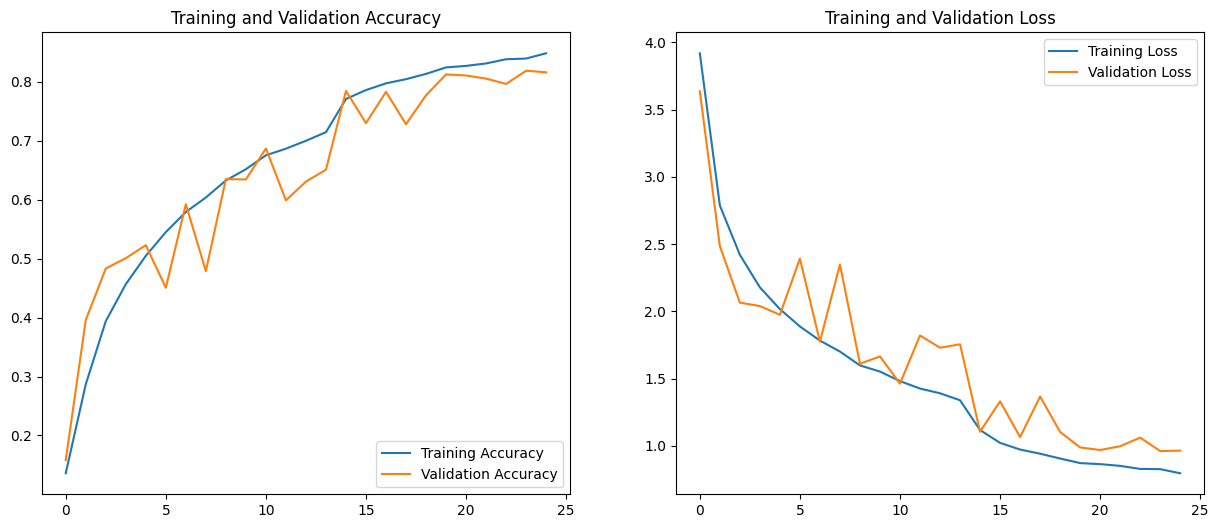

In [39]:
plot_training_history(history_2, early_stopping=early_stopping, num_of_epoch=num_of_epoch)

In [40]:
scores_train = model_2.evaluate(train_ds)
scores_val = model_2.evaluate(val_ds)
scores_test = model_2.evaluate(test_ds)
print(f"Train : {scores_train} Validation : {scores_val} Test : {scores_test}")

996/996 ━━━━━━━━━━━━━━━━━━━━ 100s 98ms/step - accuracy: 0.8988 - loss: 0.6501
214/214 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.8175 - loss: 0.9534
214/214 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - accuracy: 0.8095 - loss: 0.9643
Train : [0.6280336976051331, 0.9041922092437744] Validation : [0.9604681134223938, 0.8184349536895752] Test : [0.9339377284049988, 0.8185814619064331]


In [56]:
num_classes = train.label.nunique()

# Model tahmini
y_pred = model_2.predict(test_ds)
pred_classes = np.argmax(y_pred, axis=1)

# y_true'u numpy array olarak al
y_true = test_df['label'].to_numpy()

# Kontrol: uzunluklar eşit mi?
assert len(y_true) == len(pred_classes), "y_true ve y_pred uzunlukları eşit değil!"

# Doğru/yanlış sayıları
wrong_counts = [0] * num_classes
correct_counts = [0] * num_classes

for i in range(len(y_true)):
    label = int(y_true[i])        # tip uyuşmazlıklarını önlemek için
    pred = int(pred_classes[i])
    if pred == label:
        wrong_counts[label] += 1
    else:
        correct_counts[label] += 1

# Her sınıf için bastır
for cls in range(num_classes):
    print(f"Sınıf {cls}: Doğru = {correct_counts[cls]}, Yanlış = {wrong_counts[cls]}")

214/214 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step
Sınıf 0: Doğru = 92, Yanlış = 1
Sınıf 1: Doğru = 78, Yanlış = 0
Sınıf 2: Doğru = 76, Yanlış = 1
Sınıf 3: Doğru = 88, Yanlış = 1
Sınıf 4: Doğru = 93, Yanlış = 1
Sınıf 5: Doğru = 103, Yanlış = 2
Sınıf 6: Doğru = 101, Yanlış = 1
Sınıf 7: Doğru = 85, Yanlış = 2
Sınıf 8: Doğru = 83, Yanlış = 2
Sınıf 9: Doğru = 87, Yanlış = 2
Sınıf 10: Doğru = 77, Yanlış = 2
Sınıf 11: Doğru = 91, Yanlış = 0
Sınıf 12: Doğru = 102, Yanlış = 2
Sınıf 13: Doğru = 94, Yanlış = 1
Sınıf 14: Doğru = 84, Yanlış = 3
Sınıf 15: Doğru = 100, Yanlış = 0
Sınıf 16: Doğru = 88, Yanlış = 1
Sınıf 17: Doğru = 97, Yanlış = 0
Sınıf 18: Doğru = 91, Yanlış = 1
Sınıf 19: Doğru = 96, Yanlış = 1
Sınıf 20: Doğru = 88, Yanlış = 3
Sınıf 21: Doğru = 93, Yanlış = 1
Sınıf 22: Doğru = 96, Yanlış = 3
Sınıf 23: Doğru = 100, Yanlış = 2
Sınıf 24: Doğru = 76, Yanlış = 0
Sınıf 25: Doğru = 97, Yanlış = 1
Sınıf 26: Doğru = 96, Yanlış = 2
Sınıf 27: Doğru = 95, Yanlış = 2
Sınıf 28: Doğru = 98, Yanlış = 2
Sınıf

# Transfer Learning

In [ ]:
base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(Resize_SIZE, Resize_SIZE, 3))
# Freeze the layers except the last few layers
for layer in base_model.layers[:-15]:
    layer.trainable = False

In [ ]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(layers.Dense(75, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005), 
    metrics=['accuracy']
)

model.summary()

In [ ]:
num_of_epoch = 40
fine_tune_inception_history = model.fit(train_ds, epochs = num_of_epoch, batch_size = Batch_Size, verbose = 1, validation_data = val_ds, callbacks=[early_stopping, reduce_lr])

In [ ]:
plot_training_history(history_3, early_stopping=early_stopping, num_of_epoch=num_of_epoch)

In [ ]:
scores_train = model_3.evaluate(train_ds)
scores_val = model_3.evaluate(val_ds)
scores_test = model_3.evaluate(test_ds)
print(f"Train : {scores_train} Validation : {scores_val} Test : {scores_test}")